**Initialization of Salvus**

**ToDo**
- plot time-space traces (i.e. fixed y and varying x against time) 
- plot snapshots of the wavefield at specific times in x-y
- check wavelet so that it's at the right time

In [9]:
'''Salome Bachmann - Research Module in Applied Geophysics

Setting up a purely acoustic simulation with a point source using Salvus in homogenous media in 2D'''


# Imports (taken from salvus tutorials)
import os

SALVUS_FLOW_SITE_NAME = os.environ.get("macbook", "local") # Site name given in the installation of Salvus flow
PROJECT_DIR = "simulation_pure_acoustic"
import pathlib
import numpy as np
import salvus.namespace as sn
import xarray as xr
import salvus.namespace as sn
from salvus.project.tools.processing import block_processing
from salvus.toolbox.helpers.wavefield_output import (
    WavefieldOutput,
    wavefield_output_to_xarray,
)
import matplotlib.pyplot as plt



**Setup of Model domain**

In [ ]:
# Setup of the model domain as a box --> IS THIS CORRECT OF SHOULD THE GEOMETRY BE DIFFERENT ???????
from xml.parsers.expat import model


d = sn.domain.dim2.BoxDomain(x0=0.0, x1=2000.0, y0=0.0, y1=1000.0) 

# Initilaize project from domain 
p = sn.Project.from_domain(path=PROJECT_DIR, domain=d, load_if_exists=True)

# Delete previous events if re-running the notebook
p.events.delete(event_name="event_acoustic_hom")

# Also delete previous model configurations if re-running the notebook
path = pathlib.Path(PROJECT_DIR) / "INTERNAL" / "ENTITIES" / "SIMULATION_CONFIGURATIONS"
for file in path.glob("pure_acoustic_simulation.json"):
    file.unlink()







Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

[2025-12-22 15:25:47,080] INFO: Loading project from simulation_pure_acoustic.


** Setup of acoustic (explosive source) and strain recievers **
Point vector source because from an explosion the force radiates outward from the explosion point

In [11]:
# Source setup in the center of the model domain 
src = sn.simple_config.source.cartesian.VectorPoint2D(
    x=500.0, y=500.0, fx=1e10, fy=1e10 # fx and fy are the x and y components of the force in N I DONT KNOW WHAT VALUES THESE SHOULD BE --> RESEARCH MORE
)

# Reciever setup - strain reciebvers along the surface
recs = [
    sn.simple_config.receiver.cartesian.Point2D(
        y=1000, # Change this if recievers are buried 
        x=x,
        network_code="xx",
        station_code=f"REC{i + 1}",
        fields=["strain" ,"stress"]
    )
    for i, x in enumerate(np.linspace(1010.0, 1410.0, 10))
]

# Add sources and recievers to propject
p.add_to_project(sn.Event(event_name="event_acoustic_hom", sources=src, receivers=recs))

**Running the simulation, using parameters for snow**
Using an isotropic elastic model because there is only one material present which is assumed to be homogenous. Parameters are density of 800kg/m^3, vp of 300m/s, vs of 150m/s. Values were taken from https://tc.copernicus.org/articles/15/5805/2021/ table 2 for fresh snow

In [12]:
mc = sn.ModelConfiguration(
    background_model=sn.model.background.homogeneous.IsotropicElastic(
        rho=800.0, vp=300.0, vs=150
    )
)

**Wavelet configuration**

In [13]:
ec = sn.EventConfiguration(
    wavelet=sn.simple_config.stf.Ricker(center_frequency=3), # Center frequency is dependend on sourcve
    waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
        start_time_in_seconds=-0.5,
        end_time_in_seconds=1,
    ),
)


**Plotting source spectrum and time series of source wavelet**
This is to check the source wavelet and make sure it's at the right time

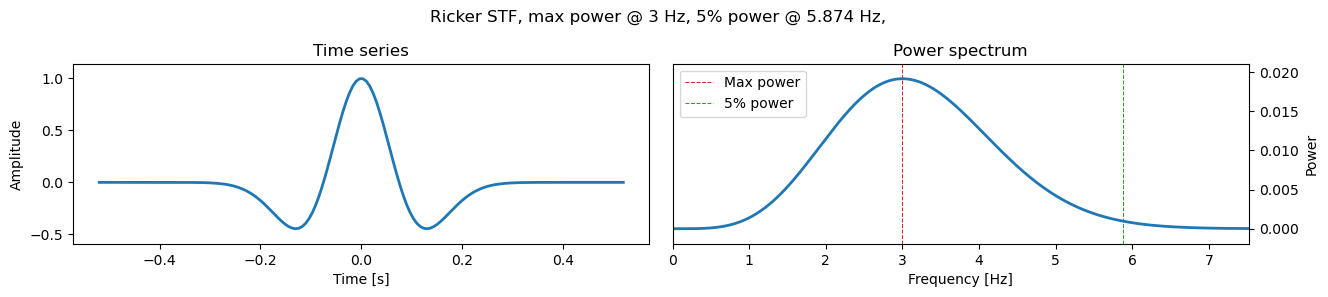

In [14]:
# Plotting source wavelet spectrum and time series usingh salvus function from. tutorial 1
ec.wavelet.plot()

**Simulation configuration**


In [15]:
p.add_to_project(
    sn.SimulationConfiguration(
        name="pure_acoustic_simulation",
        max_frequency_in_hertz=30.0,
        elements_per_wavelength=3.0,
        model_configuration=mc,
        event_configuration=ec,
    
       
    )
)

# Launich simulation
p.simulations.launch(
    ranks_per_job=2,
    site_name="macbook",
    events=p.events.list(),
    simulation_configuration="pure_acoustic_simulation",
    delete_conflicting_previous_results=True,

)

# Waiting for all simulations to be done
p.simulations.query(block=True)

[2025-12-22 15:24:55,917] INFO: Simulations of 2 event(s) are still running. They will not be submitted again.


VBox()

KeyboardInterrupt: 

In [ ]:
# # Printing the data to check which parts are there to avoid key error when plotting
# ed = p.waveforms.get("pure_acoustic_simulation", p.events.list())

# # try to get receiver data (no trailing dot in receiver name)
# try:
#     print(
#         ed[0].get_receiver_data(
#             receiver_name="XX.REC1", receiver_field="strain"
#         )
#     )
# except KeyError as e:
#     print("Receiver not found:", e)

# # Printing the keys available in the data
# try:
#     keys = ed[0].data.keys()
# except AttributeError:
#     try:
#         keys = list(ed[0].data)
#     except Exception:
#         keys = repr(ed[0].data)



**Visualization of wavelets**

In [16]:
# Plotting a shotgather
p.waveforms.get(data_name="pure_acoustic_simulation", events=p.events.list())[1].plot(
    plot_types=("wiggles",), receiver_field="strain", component="1"
)

ValueError: These events are still running: ['event_0', 'event_acoustic_hom'].

**Plotting the data using matplotlib so that plots can be adjusted**
this is done because in the plots using salvus' plot functions, the data is cut off

In [ ]:
# Plotting the data manually to adjust visualization
ed = p.waveforms.get("pure_acoustic_simulation", p.events.list())

# Seperating the data by timesteps and values at the timestepts
times, values = ed[0].get_data_cube(
    receiver_field="strain", component="1"
)

# # check time values
# print("time max: ", times.max())
# # check waveform values 
# print(ec.waveform_simulation_configuration)
# print("start:", ec.waveform_simulation_configuration.start_time_in_seconds,
#       "end:", ec.waveform_simulation_configuration.end_time_in_seconds)


# Plotting times and their values using matplotlib so that visualization can be adjusted
plt.plot(times, values.T)
plt.xlabel("Time (s)")
plt.ylabel("Strain value")
plt.title("Strain over Time at all Receivers")
plt.xlim(0.5,0.7)
plt.show()







**PLotting the individual reciever data to see what the data contains**

In [ ]:
ed = p.waveforms.get("pure_acoustic_simulation", p.events.list())
print(
    ed[0].get_receiver_data(
        receiver_name="XX.REC2.", receiver_field="strain"
    )
)
ed[0].get_receiver_data(
    receiver_name="XX.REC2.", receiver_field="strain"
).plot()

**Plotting space-time traces with fixed y and varying y**

In [ ]:
# varying x from the plots above in a loop
for x in np.linspace(1010.0, 1410.0, 10):
    print(f"Plotting for receiver at x={x}")
    ed[0].get_receiver_data(
        receiver_name=f"XX.REC{int((x-1010)/(400/9))+1}.", receiver_field="strain"
    ).plot()



Plotting for receiver at x=1010.0


NameError: name 'ed' is not defined